In [1]:
%pip install -q --upgrade keras tensorflow setuptools scikit-learn segmentation-models matplotlib opencv-python seaborn keras_tuner
print("Successfully installed required packages.")

Note: you may need to restart the kernel to use updated packages.


In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

### Run the following code in a terminal

```bash
pip install kaggle
kaggle datasets download -d tawsifurrahman/tuberculosis-tb-chest-xray-dataset
kaggle datasets download -d nikhilpandey360/chest-xray-masks-and-labels
unzip chest-xray-masks-and-labels.zip
unzip tuberculosis-tb-chest-xray-dataset.zip
rm -rf data
mv Lung\ Segmentation segmentation_data
cd segmentation_data
rm -rf ClinicalReadings
rm NLM-ChinaCXRSet-ReadMe.docx
rm NLM-MontgomeryCXRSet-ReadMe.pdf
mv CXR_png images

cd ..
mv TB_Chest_Radiography_Database data
```

In [3]:
import os
import shutil
from sklearn.model_selection import train_test_split

split_dir = './data/split'

def split_dataset(base_split_dir='./data/split', normal_dir='./data/Normal', tb_dir='./data/Tuberculosis'):
    train_split = 'train'
    test_split = 'test'
    splits = [train_split, test_split]
    normal_class = 'normal'
    tb_class = 'tuberculosis'
    classes = [normal_class, tb_class]

    normal_files = [f for f in os.listdir(normal_dir) if os.path.isfile(os.path.join(normal_dir, f))]
    tb_files = [f for f in os.listdir(tb_dir) if os.path.isfile(os.path.join(tb_dir, f))]

    if os.path.exists(base_split_dir):
        print("Removing existing dataset")
        # If the split directory exists, remove it and so it can be regenerated
        shutil.rmtree(base_split_dir)

    # Split the data into training, test sets
    # The validation set will be created from the training set at a later stage
    train_normal, test_normal = train_test_split(normal_files, test_size=0.1)
    train_tb, test_tb = train_test_split(tb_files, test_size=0.1)

    for split in splits:
        for cls in classes:
            os.makedirs(os.path.join(base_split_dir, split, cls), exist_ok=True)

    # Function to copy files to their respective directories
    def copy_files(file_list, dst_dir):
        for file in file_list:
            src_dir = normal_dir if file in normal_files else tb_dir
            shutil.copy(os.path.join(src_dir, file), os.path.join(dst_dir, file))

    print("Copying train normal set...")
    copy_files(train_normal, os.path.join(base_split_dir, train_split, normal_class))
    print("Copying test normal set...")
    copy_files(test_normal, os.path.join(base_split_dir, test_split, normal_class))

    print("Copying train normal set...")
    copy_files(train_tb, os.path.join(base_split_dir, train_split, tb_class))
    print("Copying test normal set...")
    copy_files(test_tb, os.path.join(base_split_dir, test_split, tb_class))

split_dataset(base_split_dir=split_dir)

Removing existing dataset
Copying train normal set...
Copying test normal set...
Copying train normal set...
Copying test normal set...


In [4]:
import keras

training_data = keras.utils.image_dataset_from_directory(
    split_dir + "/train",
    labels='inferred',
    label_mode='binary',
    batch_size=32,
    image_size=(256, 256),
    shuffle=True,
    seed=123,
    validation_split=0.1,
    subset='both'
)
train_dataset, validation_dataset = training_data

test = keras.utils.image_dataset_from_directory(
    split_dir + "/test",
    labels='inferred',
    label_mode='binary',
    batch_size=32,
    image_size=(256, 256),
    shuffle=True,
    seed=123
)

2024-07-21 10:39:27.905594: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-21 10:39:27.923912: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-21 10:39:27.929612: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-21 10:39:27.943381: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-21 10:39:30.327562: W tensorflow/compiler/tf2

Found 3780 files belonging to 2 classes.
Using 3402 files for training.
Using 378 files for validation.


I0000 00:00:1721558381.232162   13823 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1721558388.239185   13823 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1721558388.242916   13823 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1721558388.248565   13823 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

Found 420 files belonging to 2 classes.


In [5]:
no_weighting_model = keras.Sequential([
    keras.layers.InputLayer(shape=(256, 256, 3)),
    keras.layers.Conv2D(16, (7, 7), activation='relu'),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    keras.layers.Flatten(),
    keras.layers.Dense(100, activation='relu'),
    keras.layers.Dense(50, activation='relu'),
    keras.layers.Dense(5, activation='relu'),
    keras.layers.Dropout(0.6),
    keras.layers.Dense(1, activation='sigmoid'),
])

no_weighting_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', 'precision', 'recall'])

no_weighting_history = no_weighting_model.fit(train_dataset, epochs=10, validation_data=validation_dataset)

no_weighting_results = no_weighting_model.evaluate(test)
no_weighting_predictions = no_weighting_model.predict(test)

Epoch 1/10


I0000 00:00:1721558392.900708   16573 service.cc:146] XLA service 0x7f38f400b2f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1721558392.900745   16573 service.cc:154]   StreamExecutor device (0): NVIDIA A10G, Compute Capability 8.6
2024-07-21 10:39:52.964425: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-07-21 10:39:53.821483: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8903


  9/107 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.7409 - loss: 13.5881 - precision: 0.2632 - recall: 0.2878

I0000 00:00:1721558413.705348   16573 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


107/107 ━━━━━━━━━━━━━━━━━━━━ 32s 93ms/step - accuracy: 0.8147 - loss: 2.7348 - precision: 0.2527 - recall: 0.0446 - val_accuracy: 0.8492 - val_loss: 0.6588 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - accuracy: 0.8310 - loss: 0.6533 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.8492 - val_loss: 0.6282 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - accuracy: 0.8307 - loss: 0.6255 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.8492 - val_loss: 0.6012 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - accuracy: 0.8280 - loss: 0.6016 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.8492 - val_loss: 0.5771 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - accuracy: 0.8354 - loss: 0.5774 - precision: 0.0000e+00

In [6]:
import keras

weighting_model = keras.Sequential([
    keras.layers.InputLayer(shape=(256, 256, 3)),
    keras.layers.Conv2D(16, (7, 7), activation='relu'),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    keras.layers.Flatten(),
    keras.layers.Dense(100, activation='relu'),
    keras.layers.Dense(50, activation='relu'),
    keras.layers.Dense(5, activation='relu'),
    keras.layers.Dropout(0.6),
    keras.layers.Dense(1, activation='sigmoid'),
])

weighting_model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy', 'precision', 'recall'],
)

weighting_history = weighting_model.fit(
    train_dataset,
    epochs=10,
    validation_data=validation_dataset,
    class_weight={0: 0.2, 1: 1}
)

weighting_results = weighting_model.evaluate(test)
weighting_predictions = weighting_model.predict(test)

Epoch 1/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 9s 54ms/step - accuracy: 0.4735 - loss: 29.7301 - precision: 0.1574 - recall: 0.4663 - val_accuracy: 0.8492 - val_loss: 0.6919 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - accuracy: 0.5684 - loss: 0.2332 - precision: 0.1304 - recall: 0.3960 - val_accuracy: 0.8492 - val_loss: 0.6930 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - accuracy: 0.6055 - loss: 0.2303 - precision: 0.1236 - recall: 0.3380 - val_accuracy: 0.1508 - val_loss: 0.6935 - val_precision: 0.1508 - val_recall: 1.0000
Epoch 4/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - accuracy: 0.1691 - loss: 0.2324 - precision: 0.1691 - recall: 1.0000 - val_accuracy: 0.1508 - val_loss: 0.6944 - val_precision: 0.1508 - val_recall: 1.0000
Epoch 5/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - accuracy: 0.1676 - loss: 0.2316 - precision: 0.1676 - recall: 1.0000 - val_accuracy:

2024-07-21 10:41:46.013829: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


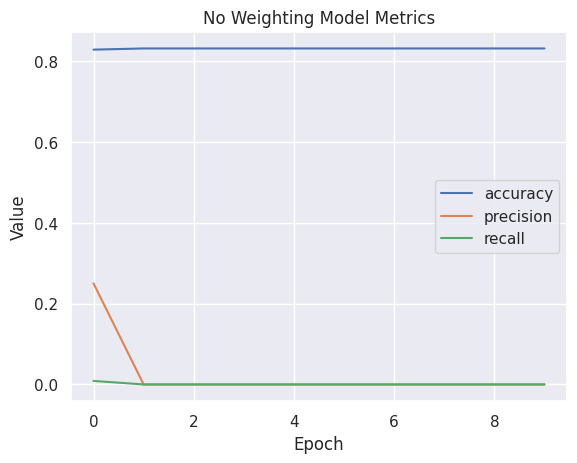

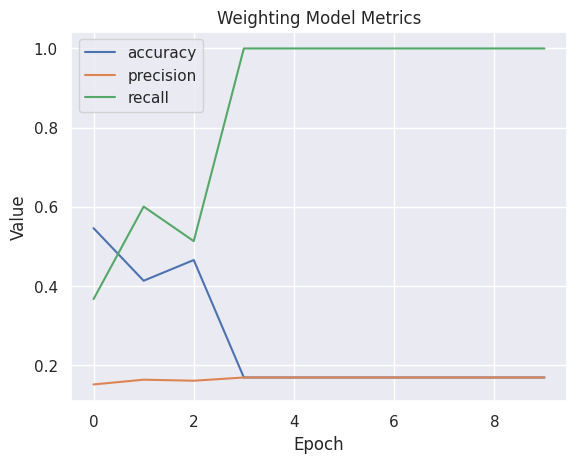

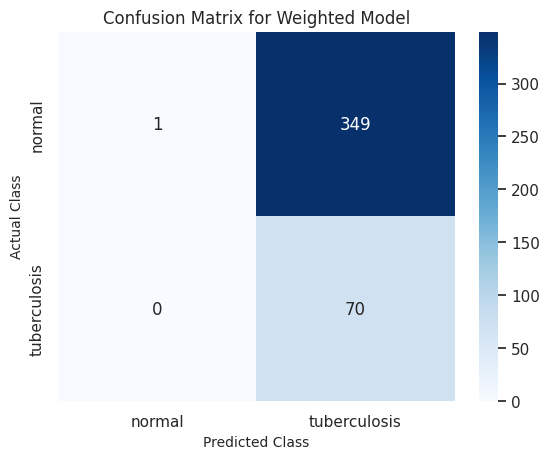

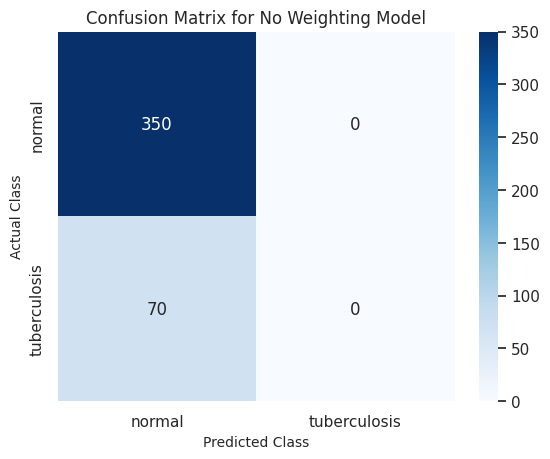

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np

sns.set_theme("notebook")

true_y = np.concatenate([y for _, y in test], axis=0).astype(int)
weighted_output = (weighting_predictions > 0.5).astype(int)
no_weighting_output = (no_weighting_predictions > 0.5).astype(int)

# plot the metrics using seaborn
def plot_metrics(history, metrics, title=None):
    for metric in metrics:
        plt.plot(history.history[metric], label=metric)
    plt.xlabel('Epoch')
    plt.ylabel('Value')
    plt.title(title)
    plt.legend()
    plt.show()

plot_metrics(no_weighting_history, ['accuracy', 'precision', 'recall'], title="No Weighting Model Metrics")
plot_metrics(weighting_history, ['accuracy', 'precision', 'recall'], title="Weighting Model Metrics")

def plot_confusion_matrix(y_true, y_pred, classes, title=None, cmap=plt.cm.Blues):
    matrix = confusion_matrix(y_true, y_pred)
    sns.heatmap(matrix, annot=True, fmt='d', cmap=cmap, xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted Class', fontsize=10)
    plt.ylabel('Actual Class', fontsize=10)
    plt.title(title, fontsize=12)
    plt.show()

plot_confusion_matrix(true_y, weighted_output, ['normal', 'tuberculosis'], title='Confusion Matrix for Weighted Model')
plot_confusion_matrix(true_y, no_weighting_output, ['normal', 'tuberculosis'], title='Confusion Matrix for No Weighting Model')

In [8]:
import os

DATA_DIR = "./segmentation_data"
image_dir = os.path.join(DATA_DIR, "images")
mask_dir = os.path.join(DATA_DIR, "masks")

masks = [f for f in os.listdir(mask_dir) if os.path.isfile(os.path.join(mask_dir, f))]
for mask in masks:
    if mask.endswith("_mask.png"):
        os.rename(os.path.join(mask_dir, mask), os.path.join(mask_dir, mask.replace("_mask", "")))

images = [f for f in os.listdir(image_dir) if os.path.isfile(os.path.join(image_dir, f))]
for img in images:
    if os.path.isfile(os.path.join(mask_dir, img)):
        continue
    os.remove(os.path.join(image_dir, img))

# Split the dataset into training and validation sets
images = [f for f in os.listdir(image_dir) if os.path.isfile(os.path.join(image_dir, f))]
masks = [f for f in os.listdir(mask_dir) if os.path.isfile(os.path.join(mask_dir, f))]

In [9]:
images = [f for f in os.listdir(image_dir) if os.path.isfile(os.path.join(image_dir, f))]
masks = [f for f in os.listdir(mask_dir) if os.path.isfile(os.path.join(mask_dir, f))]

train_images, val_images, train_masks, val_masks = train_test_split(images, masks, test_size=0.1)

if os.path.exists(os.path.join(DATA_DIR, "train")):
    print("Removing existing train dataset...")
    shutil.rmtree(os.path.join(DATA_DIR, "train"))

if os.path.exists(os.path.join(DATA_DIR, "val")):
    print("Removing existing validation dataset...")
    shutil.rmtree(os.path.join(DATA_DIR, "val"))

train_image_dir = os.path.join(DATA_DIR, "train", "images")
val_image_dir = os.path.join(DATA_DIR, "val", "images")
train_mask_dir = os.path.join(DATA_DIR, "train", "masks")
val_mask_dir = os.path.join(DATA_DIR, "val", "masks")

os.makedirs(train_image_dir, exist_ok=True)
os.makedirs(val_image_dir, exist_ok=True)
os.makedirs(train_mask_dir, exist_ok=True)
os.makedirs(val_mask_dir, exist_ok=True)

def copy_files(file_list, src_dir, dst_dir):
    for file in file_list:
        shutil.copy(os.path.join(src_dir, file), os.path.join(dst_dir, file))

print("Copying train images...")
copy_files(train_images, image_dir, train_image_dir)
print("Copying validation images...")
copy_files(val_images, image_dir, val_image_dir)
print("Copying train masks...")
copy_files(train_masks, mask_dir, train_mask_dir)
print("Copying validation masks...")
copy_files(val_masks, mask_dir, val_mask_dir)

Removing existing train dataset...
Removing existing validation dataset...
Copying train images...
Copying validation images...
Copying train masks...
Copying validation masks...


In [10]:
import keras
import tensorflow as tf

train_masks_dir = os.path.join(DATA_DIR, "train", "masks")
train_images_dir = os.path.join(DATA_DIR, "train", "images")
val_masks_dir = os.path.join(DATA_DIR, "val", "masks")
val_images_dir = os.path.join(DATA_DIR, "val", "images")

train_masks = keras.utils.image_dataset_from_directory(
    train_masks_dir,
    label_mode=None,
    color_mode='grayscale',
    batch_size=16,
    image_size=(256, 256)
)

train_images = keras.utils.image_dataset_from_directory(
    train_images_dir,
    label_mode=None,
    color_mode='grayscale',
    batch_size=16,
    image_size=(256, 256)
)

val_masks = keras.utils.image_dataset_from_directory(
    val_masks_dir,
    label_mode=None,
    color_mode='grayscale',
    batch_size=16,
    image_size=(256, 256)
)

val_images = keras.utils.image_dataset_from_directory(
    val_images_dir,
    label_mode=None,
    color_mode='grayscale',
    batch_size=16,
    image_size=(256, 256)
)

train_dataset = tf.data.Dataset.zip((train_images, train_masks))
val_dataset = tf.data.Dataset.zip((val_images, val_masks))

train_dataset = train_dataset.map(lambda x, y: (x / 255.0, y / 255.0))
val_dataset = val_dataset.map(lambda x, y: (x / 255.0, y / 255.0))

Found 633 files.
Found 633 files.
Found 71 files.
Found 71 files.


In [11]:
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"

import segmentation_models as sm

BACKBONE = 'resnet34'
early_stopper = keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)

base_model = sm.Unet(
    BACKBONE,
    encoder_weights='imagenet',
)

inp = keras.layers.Input(shape=(256, 256, 1))
l1 = keras.layers.Conv2D(3, (1, 1))(inp)
out = base_model(l1)

model = keras.models.Model(inp, out, name=base_model.name)

model.compile(
    keras.optimizers.Adam(learning_rate=0.001),
    loss=sm.losses.DiceLoss(),
    metrics=[sm.metrics.iou_score, sm.metrics.FScore],
)

history = model.fit(train_dataset,
    epochs=5,
    validation_data=val_dataset,
    callbacks=[early_stopper]
)

Segmentation Models: using `tf.keras` framework.
85521592/85521592 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/5
40/40 ━━━━━━━━━━━━━━━━━━━━ 89s 970ms/step - f1-score: 0.5661 - iou_score: 0.4055 - loss: 0.4340 - val_f1-score: 0.3918 - val_iou_score: 0.2437 - val_loss: 0.6080
Epoch 2/5
40/40 ━━━━━━━━━━━━━━━━━━━━ 16s 376ms/step - f1-score: 0.7543 - iou_score: 0.6061 - loss: 0.2458 - val_f1-score: 0.5430 - val_iou_score: 0.3736 - val_loss: 0.4618
Epoch 3/5
40/40 ━━━━━━━━━━━━━━━━━━━━ 16s 376ms/step - f1-score: 0.7785 - iou_score: 0.6377 - loss: 0.2215 - val_f1-score: 0.6644 - val_iou_score: 0.4980 - val_loss: 0.3352
Epoch 4/5
40/40 ━━━━━━━━━━━━━━━━━━━━ 16s 375ms/step - f1-score: 0.7829 - iou_score: 0.6438 - loss: 0.2171 - val_f1-score: 0.7168 - val_iou_score: 0.5591 - val_loss: 0.2782
Epoch 5/5
40/40 ━━━━━━━━━━━━━━━━━━━━ 16s 377ms/step - f1-score: 0.7838 - iou_score: 0.6450 - loss: 0.2162 - val_f1-score: 0.7529 - val_iou_score: 0.6042 - val_loss: 0.2471


Found 96 files.
6/6 ━━━━━━━━━━━━━━━━━━━━ 34s 5s/step


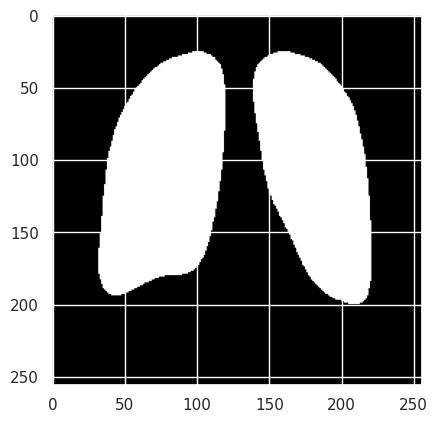

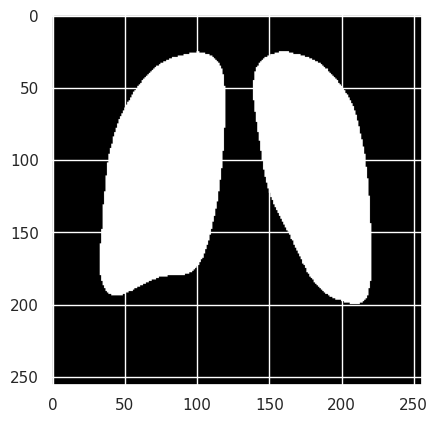

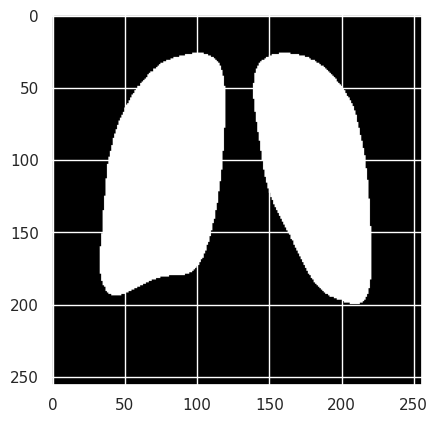

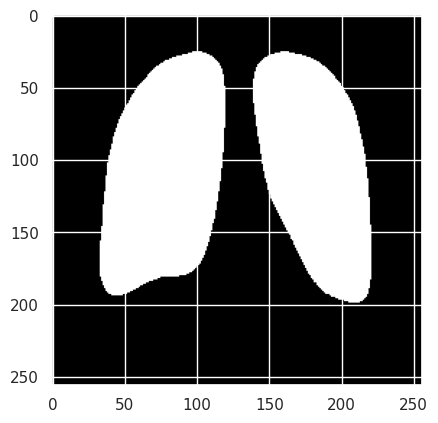

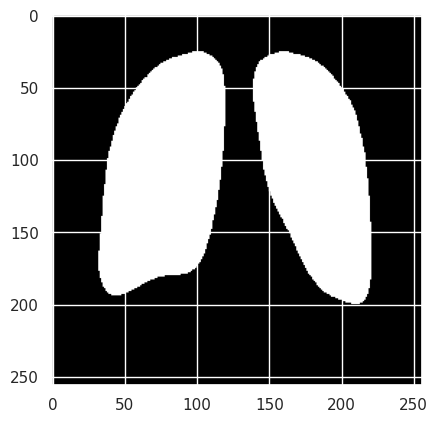

In [12]:
import numpy as np
import matplotlib.pyplot as plt

test_images_dir = os.path.join(DATA_DIR, "test")
test_images = keras.utils.image_dataset_from_directory(
    test_images_dir,
    label_mode=None,
    color_mode='grayscale',
    batch_size=16,
    image_size=(256, 256)
)

results = model.predict(test_images)
for i in range(5):
    pred = results[i]
    pred = np.squeeze(pred)
    pred = (pred > 0.5).astype(np.uint8)
    plt.imshow(pred, cmap='gray')
    plt.show()


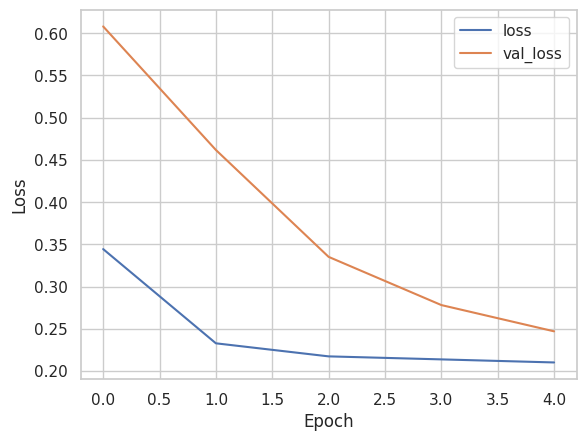

In [13]:
# plot the loss and validation loss using seaborn

import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style('whitegrid')
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [14]:
test_filenames = os.listdir(test_images_dir)

if os.path.exists(os.path.join(DATA_DIR, "out")):
    print("Removing existing output directory...")
    shutil.rmtree(os.path.join(DATA_DIR, "out"))

os.makedirs(os.path.join(DATA_DIR, "out"), exist_ok=True)
out_dir = os.path.join(DATA_DIR, "out")
for pred, fn in zip(results, test_filenames):
    pred = np.squeeze(pred)
    pred = (pred > 0.5).astype(np.uint8)
    plt.imsave(os.path.join(out_dir, fn), pred, cmap="gray")

Removing existing output directory...


In [15]:
import cv2
import os
import numpy as np

overlayed_out = os.path.join(DATA_DIR, "overlayed_out")

os.makedirs(overlayed_out, exist_ok=True)

def overlay_mask_on_image(image, mask):
    mask = mask > 0.5
    overlay_image = np.zeros_like(image)
    overlay_image[mask] = image[mask]

    return overlay_image

for img_name in os.listdir(test_images_dir):
    img_path = os.path.join(test_images_dir, img_name)
    mask_path = os.path.join(out_dir, img_name)
    
    original_image = cv2.imread(img_path)
    original_image = cv2.resize(original_image, (256, 256))
    
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    mask = cv2.resize(mask, (256, 256))
    mask = mask / 255.0
    
    overlay_image = overlay_mask_on_image(original_image, mask)

    cv2.imwrite(os.path.join(overlayed_out, img_name), overlay_image)


## Developing the Classification Model

### Finding the optimal architecture
This will start with a Grid-Search approach, to find the general direction in which to move. Once that is done a human-directed approach will begin. At this stage it is purely about finding the optimal number of layers and neurons per layer.

At this stage the focus will be on the convolutional layers, while keeping the densely connected layers stable.

In [16]:
# import tensorflow as tf
# import keras_tuner

# def build_model(hp, deterministic=True):
#     if deterministic == True:
#         tf.keras.utils.set_random_seed(1)

#     conv_kernal_size = hp.Choice(name="conv_kernal_size", values=[7, 16, 32])
#     pooling_size = hp.Choice(name="pooling_size", values=[2, 4, 8])

#     model = keras.models.Sequential([
#         keras.layers.InputLayer(shape=(256, 256, 3)),
#         keras.layers.Conv2D(hp.Choice(name="conv_filters", values=[16, 24, 36]), (conv_kernal_size, conv_kernal_size), activation='relu'),
#         keras.layers.MaxPooling2D(pool_size=(pooling_size, pooling_size)),
#         keras.layers.Flatten(),
#         keras.layers.Dense(100, activation='relu'),
#         keras.layers.Dense(50, activation='relu'),
#         keras.layers.Dense(5, activation='relu'),
#         keras.layers.Dropout(0.6),
#         keras.layers.Dense(1, activation='sigmoid'),
#     ])

#     model.compile(
#         optimizer='rmsprop',
#         loss='binary_crossentropy',
#         metrics=['accuracy', 'precision', 'recall'],
#     )

#     return model

In [17]:
# training_data = keras.utils.image_dataset_from_directory(
#     split_dir + "/train",
#     labels='inferred',
#     label_mode='binary',
#     batch_size=32,
#     image_size=(256, 256),
#     shuffle=True,
#     seed=123,
#     validation_split=0.1,
#     subset='both'
# )
# train_dataset, validation_dataset = training_data

# test = keras.utils.image_dataset_from_directory(
#     split_dir + "/test",
#     labels='inferred',
#     label_mode='binary',
#     batch_size=32,
#     image_size=(256, 256),
#     shuffle=True,
#     seed=123
# )

# cb = keras.callbacks.EarlyStopping(
#     monitor="val_loss",
#     patience=3,
#     min_delta=0.01,
#     mode="auto",
# )

# tuner = keras_tuner.GridSearch(
#     build_model,
#     objective='val_loss',
#     project_name="model_same_no_layers"
# )

# tuner.search(train_dataset, validation_data=validation_dataset, epochs=10, callbacks=[cb])

## Increasing Layers

Looking at the evaluation performed above there is still a precision of 0 in all cases. However looking at the top results, we can see that more power generally performed better than less power.

## Next Steps

In the next steps I will look at using another existing architecture which was used for [pneumonia binary classification](https://ieeexplore.ieee.org/abstract/document/8985057). TODO: Further explain the architecture

In [22]:
import tensorflow as tf
import keras
import keras_tuner

def build_model(hp, deterministic=True):
    if deterministic == True:
        tf.keras.utils.set_random_seed(1)


    model = keras.models.Sequential([
        keras.layers.InputLayer(shape=(256, 256, 3)),
        keras.layers.Conv2D(64, (3, 3), activation='relu'),
        keras.layers.MaxPooling2D(pool_size=(2, 2)),
        keras.layers.Conv2D(128, (3, 3), activation='relu'),
        keras.layers.MaxPooling2D(pool_size=(2, 2)),
        keras.layers.Conv2D(256, (3, 3), activation='relu'),
        keras.layers.Conv2D(256, (3, 3), activation='relu'),
        keras.layers.Conv2D(128, (3, 3), activation='relu'),
        keras.layers.MaxPooling2D(pool_size=(2, 2)),
        keras.layers.Flatten(),
        keras.layers.Dense(4096, activation='relu'),
        keras.layers.Dense(4096, activation='relu'),
        # keras.layers.Dropout(0.6),
        keras.layers.Dense(1, activation='sigmoid'),
    ])

    model.compile(
        optimizer='rmsprop',
        loss='binary_crossentropy',
        metrics=['accuracy', 'precision', 'recall'],
    )

    return model

In [23]:
training_data = keras.utils.image_dataset_from_directory(
    split_dir + "/train",
    labels='inferred',
    label_mode='binary',
    batch_size=32,
    image_size=(256, 256),
    shuffle=True,
    seed=123,
    validation_split=0.1,
    subset='both'
)
train_dataset, validation_dataset = training_data

test = keras.utils.image_dataset_from_directory(
    split_dir + "/test",
    labels='inferred',
    label_mode='binary',
    batch_size=32,
    image_size=(256, 256),
    shuffle=True,
    seed=123
)

cb = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=3,
    min_delta=0.01,
    mode="auto",
)

tuner = keras_tuner.GridSearch(
    build_model,
    objective='val_loss',
    project_name="model_initial_new_arch"
)

tuner.search(
    train_dataset,
    validation_data=validation_dataset,
    epochs=10,
    callbacks=[cb]
)

Found 3780 files belonging to 2 classes.
Using 3402 files for training.
Using 378 files for validation.
Found 420 files belonging to 2 classes.
Reloading Tuner from ./initial_new_arch/tuner0.json


In [24]:
# Adding class weights

weighted_tuner = keras_tuner.GridSearch(
    build_model,
    objective='val_loss',
    project_name="model_initial_new_arch_weighted"
)

weighted_tuner.search(
    train_dataset,
    validation_data=validation_dataset,
    epochs=10,
    callbacks=[cb],
    class_weight={0: 0.25, 1: 1}
  )

Reloading Tuner from ./initial_new_arch_weighted/tuner0.json


## Comparing the weighting

I trained two different models I am now going to explore their accuracy, precision and accuracy.

/home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - accuracy: 0.8810 - loss: 0.2141 - precision: 0.6172 - recall: 0.6954
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - accuracy: 0.9172 - loss: 0.5021 - precision: 0.8693 - recall: 0.5725


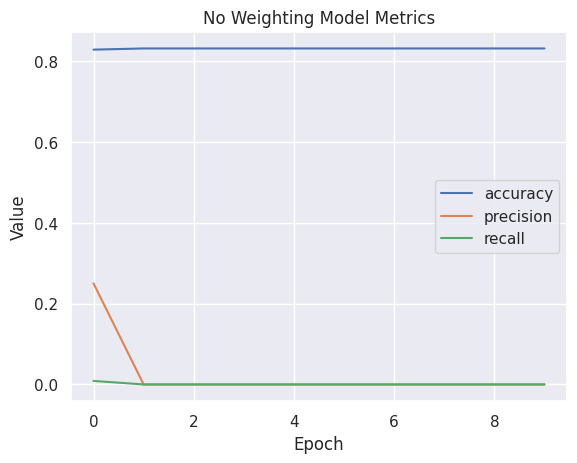

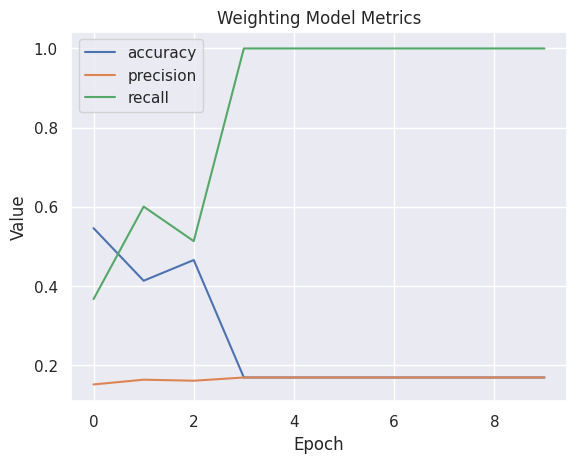

ValueError: Found input variables with inconsistent numbers of samples: [420, 4]

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np


best_model = tuner.get_best_models()[0]
best_model_weighted = weighted_tuner.get_best_models()[0]

no_weighting_results = best_model.evaluate(test)
no_weighting_predictions = best_model.predict(test)

weighting_predictions = best_model_weighted.predict(test)
weighting_predictions = best_model_weighted.evaluate(test)

sns.set_theme("notebook")

true_y = np.concatenate([y for _, y in test], axis=0).astype(int)
weighted_output = (np.array(weighting_predictions) > 0.5).astype(int)
no_weighting_output = (np.array(no_weighting_predictions) > 0.5).astype(int)

# plot the metrics using seaborn
def plot_metrics(history, metrics, title=None):
    for metric in metrics:
        plt.plot(history.history[metric], label=metric)
    plt.xlabel('Epoch')
    plt.ylabel('Value')
    plt.title(title)
    plt.legend()
    plt.show()

plot_metrics(no_weighting_history, ['accuracy', 'precision', 'recall'], title="No Weighting Model Metrics")
plot_metrics(weighting_history, ['accuracy', 'precision', 'recall'], title="Weighting Model Metrics")

def plot_confusion_matrix(y_true, y_pred, classes, title=None, cmap=plt.cm.Blues):
    matrix = confusion_matrix(y_true, y_pred)
    sns.heatmap(matrix, annot=True, fmt='d', cmap=cmap, xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted Class', fontsize=10)
    plt.ylabel('Actual Class', fontsize=10)
    plt.title(title, fontsize=12)
    plt.show()

plot_confusion_matrix(true_y, weighted_output, ['normal', 'tuberculosis'], title='Confusion Matrix for Weighted Model')
plot_confusion_matrix(true_y, no_weighting_output, ['normal', 'tuberculosis'], title='Confusion Matrix for No Weighting Model')